In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"herutriana","key":"37b33345dd9a68fe723fa5314cd6f6fd"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ckay16/accident-detection-from-cctv-footage

 93% 233M/249M [00:02<00:00, 71.0MB/s]
100% 249M/249M [00:02<00:00, 88.9MB/s]


In [ ]:
import tensorflow as tensor
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile,os
zip_lcl = '/content/accident-detection-from-cctv-footage.zip'
rzip = zipfile.ZipFile(zip_lcl, 'r')
rzip.extractall('/tmp')
rzip.close()

dirbase = '/tmp/data'
dir_latih = os.path.join(dirbase, 'train')
dir_valid = os.path.join(dirbase, 'val')
dir_test = os.path.join(dirbase,'test')
accident_test = os.path.join(dir_test,'Accident')
nonaccident_test = os.path.join(dir_test,'Non Accident')

In [ ]:
os.listdir('/tmp/data/train')

['Accident', 'Non Accident']

In [ ]:
os.listdir('/tmp/data/val')

['Accident', 'Non Accident']

In [ ]:
imagesize = 300

In [ ]:
data_latih = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0)
data_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.9,
    shear_range=0)

In [ ]:
generator_latih = data_latih.flow_from_directory(
    directory=dir_latih,
    target_size=(imagesize,imagesize),
    batch_size=100,
    subset='training',
    class_mode='binary')
generator_valid = data_valid.flow_from_directory(
    directory=dir_valid,
    target_size=(imagesize,imagesize),
    batch_size=100,
    subset='validation',
    class_mode='binary')

Found 791 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = tensor.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(imagesize, imagesize, 3))
model.trainable = False

# Menambahkan lapisan Dense di atas model VGG16
top_model = tensor.keras.models.Sequential()
top_model.add(tensor.keras.layers.Flatten(input_shape=model.output_shape[1:]))
top_model.add(tensor.keras.layers.Dense(256, activation='relu'))
top_model.add(tensor.keras.layers.Dense(1, activation='sigmoid'))

model = tensor.keras.models.Model(inputs=model.input, outputs=top_model(model.output))

# Print the summary of the model
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                              

In [ ]:
from tensorflow.keras import metrics

model.compile(loss='binary_crossentropy',
              optimizer=tensor.optimizers.Adam(),
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])


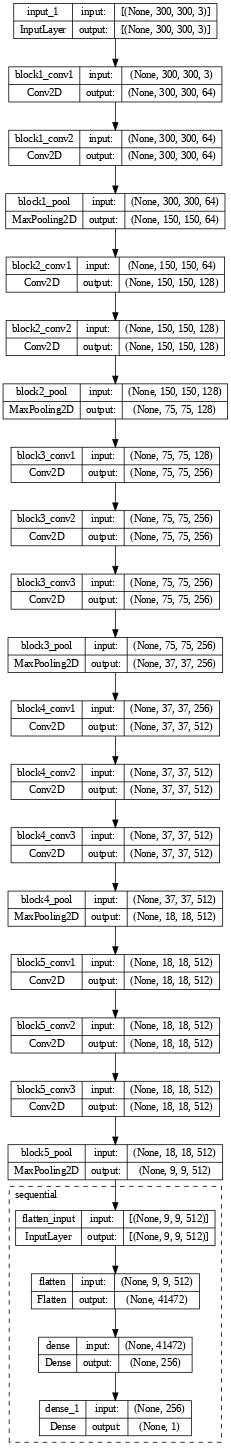

In [ ]:
model_viz = tensor.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

cekmodel = ModelCheckpoint(filepath='model.hdf5',monitor='val_accuracy',mode='max',verbose=2,save_best_only=True)

In [ ]:
class myCallback(tensor.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.972):
      print("\nAkurasi di atas 97%, hentikan training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
    generator_latih,
    #steps_per_epoch=25, # 634 images = batch_size * steps
    epochs=150,
    validation_data=generator_valid,
    #validation_steps=6, # 96 images = batch_size * steps
    verbose=2,
    callbacks=[callbacks]
    )

Epoch 1/150
8/8 - 101s - loss: 5.7365 - accuracy: 0.5284 - recall: 0.6019 - precision: 0.5534 - val_loss: 2.3848 - val_accuracy: 0.4713 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 101s/epoch - 13s/step
Epoch 2/150
8/8 - 32s - loss: 1.3126 - accuracy: 0.5044 - recall: 0.7227 - precision: 0.5259 - val_loss: 0.6153 - val_accuracy: 0.6897 - val_recall: 0.5652 - val_precision: 0.7879 - 32s/epoch - 4s/step
Epoch 3/150
8/8 - 33s - loss: 0.7604 - accuracy: 0.5777 - recall: 0.3697 - precision: 0.6964 - val_loss: 0.6264 - val_accuracy: 0.6667 - val_recall: 0.9783 - val_precision: 0.6164 - 33s/epoch - 4s/step
Epoch 4/150
8/8 - 33s - loss: 0.5956 - accuracy: 0.6827 - recall: 0.8768 - precision: 0.6503 - val_loss: 0.6387 - val_accuracy: 0.6437 - val_recall: 0.3696 - val_precision: 0.8947 - 33s/epoch - 4s/step
Epoch 5/150
8/8 - 32s - loss: 0.5483 - accuracy: 0.7042 - recall: 0.7227 - precision: 0.7227 - val_loss: 0.5116 - val_accuracy: 0.7586 - val_recall: 0.8696 - val_precision: 0.7273 -

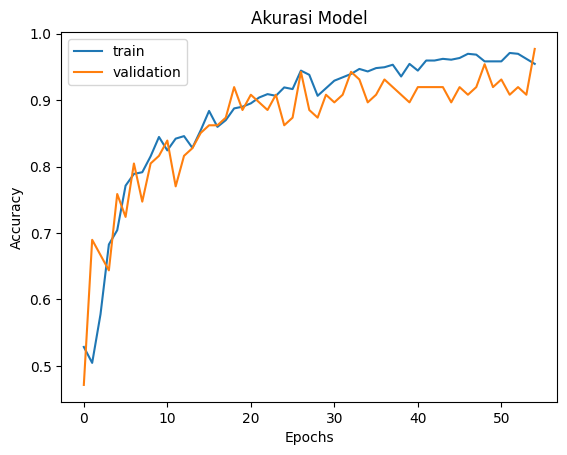

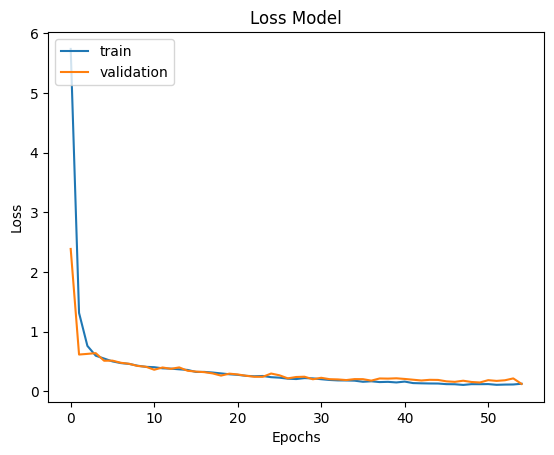

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

1/1 [==============================] - 3s 3s/step


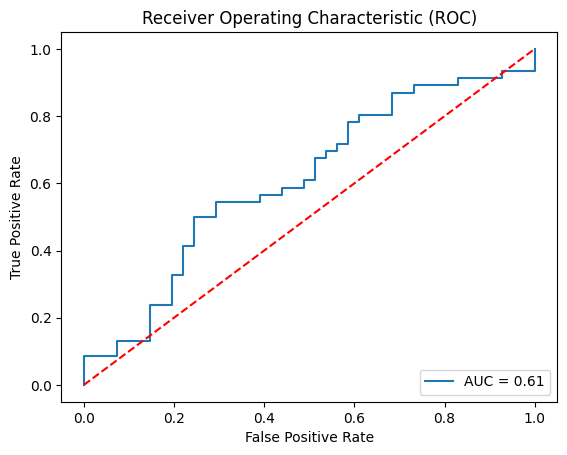

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Memprediksi probabilitas kelas positif
y_pred = model.predict(generator_valid)

# Mendapatkan label aktual dari data validasi
y_true = generator_valid.classes

# Menghitung nilai false positive rate (fpr) dan true positive rate (tpr) untuk kurva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Menghitung AUC (Area Under the Curve) untuk kurva ROC
auc = roc_auc_score(y_true, y_pred)

# Menampilkan kurva ROC
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Mendapatkan nilai precision dan recall dari history
precision = history.history['precision']
recall = history.history['recall']

precision_val = history.history['val_precision']
recall_val = history.history['val_recall']


# Mengambil nilai terakhir dari list precision dan recall
final_precision = precision[-1]
final_recall = recall[-1]

final_precision_val = precision_val[-1]
final_recall_val = recall_val[-1]

# Menghitung F1-score
f1_score = 2 * (final_precision * final_recall) / (final_precision + final_recall)
f1_score_val = 2 * (final_precision_val * final_recall_val) / (final_precision_val + final_recall_val)

# Menampilkan nilai F1-score terakhir
print(f'Final F1-score: {f1_score:.2f}')
print(f'Final F1-score Validation: {f1_score_val:.2f}')

Final F1-score: 0.96
Final F1-score Validation: 0.98


In [ ]:
# Convert the model.
converter = tensor.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('accident_classification.tflite', 'wb') as f:
  f.write(tflite_model)

model.save('accident_classification.pb')
!cd